# Facial recognition convolutional neural network, multi class and multi label

In [1]:
import numpy as np #  provides a multidimensional array object
import matplotlib.pyplot as plt # library for visualizations, graphs
import matplotlib.image as mping # used to read image paths
import tensorflow as tf # machine learning framework
import matplotlib.pyplot as plt # graph plotting library
import pandas as pd # data manipluation
import cv2 # computer vision library
from sklearn.metrics import confusion_matrix # plotting tool for confususion matrix
import skimage.io as io # read write images in various formats
import itertools # Functions creating iterators for efficient looping
import random # used to generate random numbers
from PIL import Image # python image libary
import os # OS manipuilation 
from matplotlib import pyplot
from sklearn.model_selection import train_test_split # used to split the dataset into training and testing data
# importing modules from tensorflow.keras to keep code readable
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D, Activation,MaxPool2D,GlobalMaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,RMSprop
from imgaug import augmenters as iaa # image augmentation library
%matplotlib inline

import ntpath

In [2]:
print("Tensorflow version:",tf.__version__) # check tensorflow version

Tensorflow version: 2.2.0


### Variables

In [3]:
root = "/home/michael/DataSciMSc/comp1804-AppliedML/coursework/data/" # parent folder to save all data
image_data = 'dataset'
video_data = 'video'

In [4]:
dataset_dict = {
    'wrinkles_id':{
        0: 'does not have',
        1: 'has'
    },
    'freckles_id' :{
        0: 'does not have',
        1: 'has'
    },
    'glasses_id' :{
        0: 'does not have',
        1: 'wear normal',
        2: 'wear sunglasses'
    },
    'hair_colour_id' :{
        0: 'brown',
        1: 'black',
        2: 'grey',
        3: 'blonde',
        4: 'red',
        5: 'white',
        6: 'mixed',
        7: 'other',
        8: 'not visible'
    },
    'hair_top_id':{
        0: 'bald or shaved',
        1: 'has few hair',
        2: 'has thick hair',
        3: 'not visible'
    },
    'human_id':{
        0: 'human',
        1: 'Not Human'
    }
}

### Hyperperameters

In [52]:
MODEL_NAME = "model_14" # name of model
BATCH_SIZE = 64 # batch size to pass while training
EPOCS = 20 # number of epochs to run
STEPS = 100
ACTIVATION_LAYER = "relu"  # activation function
ACTIVATION_OUTPUT = "softmax" # output activation function
OPTIMIZER = 'RMSProp' # optimiser

### Directory checking or creation

In [6]:
# Model data files
if not os.path.exists('%s/Model_Data/%s' %(root, MODEL_NAME)):
    os.makedirs('%s/Model_Data/%s' %(root, MODEL_NAME))
    print("***\nNew model directory created\n***")
else:
    print("***\nModel directory already present\n***")
# file for plots
if not os.path.exists('%s/plots'%(root)):
    os.makedirs('%s/plots'%(root))
    print("***\n New plot directory created\n***")
else:
    print("***\nPlot directory already present\n***")


***
New model directory created
***
***
Plot directory already present
***


### Load csv file with file locations and annotations

In [7]:
# reading the csv file that has been generated
data = pd.read_csv(os.path.join(root,'dataset.csv'))#, names = CATEGORIES)  # joins the data together
# displays the output on a single line
pd.set_option('display.max_colwidth', None)
# read the first 5 lines to test the current code is working
data.head()

image_name  \
0   /home/michael/DataSciMSc/comp1804-AppliedML/coursework/data/dataset/unsplash_805.jpg   
1   /home/michael/DataSciMSc/comp1804-AppliedML/coursework/data/dataset/unsplash_830.jpg   
2  /home/michael/DataSciMSc/comp1804-AppliedML/coursework/data/dataset/unsplash_1060.jpg   
3  /home/michael/DataSciMSc/comp1804-AppliedML/coursework/data/dataset/unsplash_1136.jpg   
4  /home/michael/DataSciMSc/comp1804-AppliedML/coursework/data/dataset/unsplash_1342.jpg   

   wrinkles  freakles  glasses  hair_color  hair_top  not_human  
0         0         0        0           1         2          0  
1         0         0        1           8         3          0  
2         0         0        0           4         2          0  
3         0         0        0           1         2          0  
4         0         0        0           3         2          0

In [8]:
# function that takes in the path arguement and splits the path
def path_leaf(path):
  head, tail = ntpath.split(path) # splits the path
  return tail # returns the tail end of the split path

# data frame serise type, invoking the function path_leaf
data['image_name'] = data['image_name'].apply(path_leaf) # this takes the entire data frame and returns only the tail end of the path
#outputs the data
print(data.head())
print("Total data lenght:", len(data))

          image_name  wrinkles  freakles  glasses  hair_color  hair_top  \
0   unsplash_805.jpg         0         0        0           1         2   
1   unsplash_830.jpg         0         0        1           8         3   
2  unsplash_1060.jpg         0         0        0           4         2   
3  unsplash_1136.jpg         0         0        0           1         2   
4  unsplash_1342.jpg         0         0        0           3         2   

   not_human  
0          0  
1          0  
2          0  
3          0  
4          0  
Total data lenght: 2153


In [9]:
# function takes numpy array and checks unique element count, returns array
def count_freq(numpy_data):
    (unique, counts) = np.unique(numpy_data, return_counts=True)
    frequencies = np.asarray((unique, counts)).T   # hold the frequency of each value
    return frequencies  

In [10]:
# function takes in numpy array and string, output bar graphs showing 
# distribution of training and testing data
def plot_freq(frequency, title, labels,filename=""):
    #labels = frequency[:,0] # labels for x axis
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1]) # axes is absolute coordinates on plot
    
    ax.bar(frequency[0:10, 0],frequency[0:10, 1]) # x and y axis for plot
    plt.xticks(frequency[0:10, 0], labels=labels, rotation = 45) # define the x labels
    plt.title(title) # title
    plt.xlabel("Hair Colour") # x axis label
    plt.ylabel("Number of images")# y axis label
    # loop to get frequency data and display on chart
    for index,data in enumerate(frequency[0:10, 1]):
        # position the text data 
        plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=10),ha="center")
    if not os.path.exists("%s/plots/%s.png"% (root,filename)):
        plt.savefig("%s/plots/%s.png"% (root,filename),bbox_inches='tight')

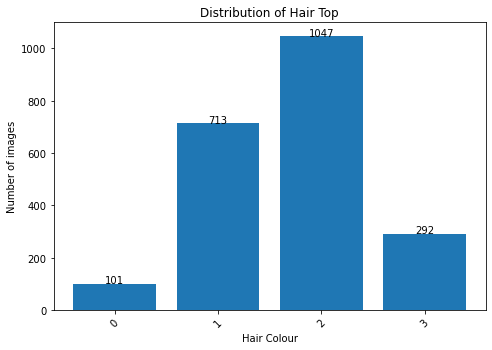

In [11]:
plot_freq(count_freq(data['hair_top']), "Distribution of Hair Top", dataset_dict['hair_top_id'],"hair_top extra input")

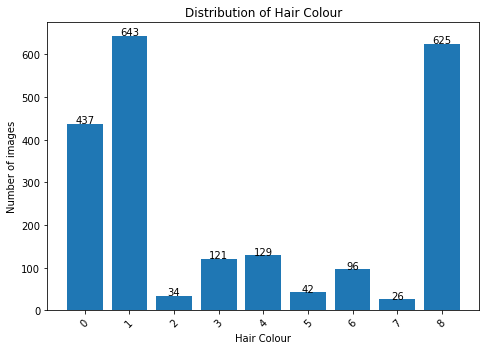

In [12]:
plot_freq(count_freq(data['hair_color']), "Distribution of Hair Colour", dataset_dict['hair_colour_id'],"Hair_Colour extra input")

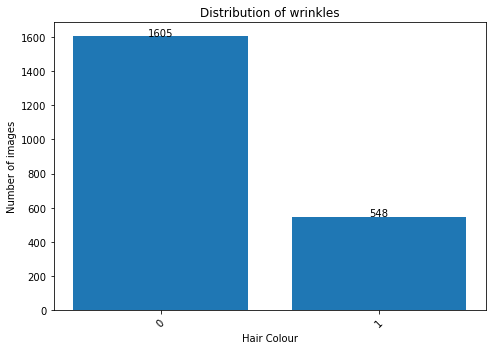

In [13]:
plot_freq(count_freq(data['wrinkles']), "Distribution of wrinkles", dataset_dict['wrinkles_id'],'wrinkles extra input')

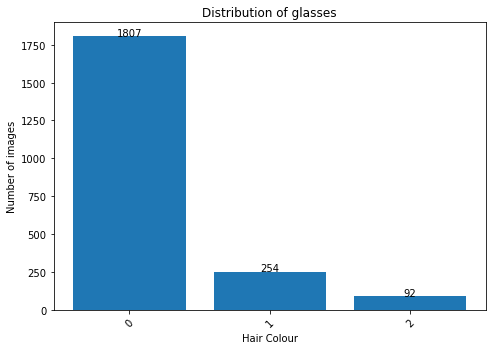

In [14]:
plot_freq(count_freq(data['glasses']), "Distribution of glasses", dataset_dict['glasses_id'],"glasses extra input")

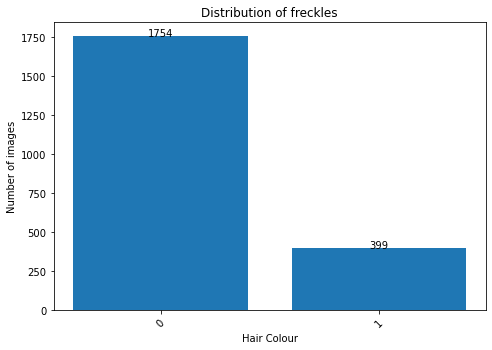

In [15]:
plot_freq(count_freq(data['freakles']), "Distribution of freckles", dataset_dict['freckles_id'],"freckles extra input")

### the following cells were used to try and balance the dataset by removing items from the dataframe and setting each class to have a maximum of 129 items in each class

In [16]:
# visualising the data of hair colour into a histogram 
#num_bins = 9 # odd number picked as there are 9 classes
#samples_per_bin = 129 # sets the maximum number of samples per bin to 129, this stops the bias to one class
#hist, bins = np.histogram(data['hair_color'], num_bins) # accessing all the data divided by 9 bins
#center = (bins[:-1] + bins[1:]) * 0.5 # element wise addition between the 2 segments, this centers the bins around 0
#plt.bar(center, hist, width = 1) # plotting the histogram on a bar graph shows the frequency of hair color
#plt.plot((np.min(data['hair_color']),np.max(data['hair_color'])), (samples_per_bin, samples_per_bin,),color='red') # displays a line where anything under the line will be used 


In [17]:
#print('Total data:', len(data)) # shows the length of the data at the start
#remove_list = [] # empty list for data that will be removed 
# looping throught all the data 
#for j in range(num_bins):
#  list_ = [] # empty list
#  for i in range(len(data['hair_color'])): # loop through the hair colour
#    if data['hair_color'][i] >= bins[j] and data['hair_color'][i] <= bins[j+1]: # isolate the hair colour with the bin currently being itterated through
#      list_.append(i) # appends the data to a list
#  list_ = list_[samples_per_bin:] # isolate the bins that go beyond the threshold of 200
#  remove_list.extend(list_) # speards the contents of the data removed into removed list

#print('Removed:', len(remove_list)) # shows the lenght of the removed data
#data.drop(data.index[remove_list], inplace=True) # drops specfic rows of data that corrisonds to the remove_list, inplace = True is updated value remains on the same copy
#print('Remaining:', len(data)) # shows the length of the data that is remaining 

#hist, _ = np.histogram(data['hair_color'], (num_bins)) # takes all steering data and 
#plt.bar(center, hist, width = 0.8) # plotting the histogram on a bar graph shows the frequency of steering angle
#plt.plot((np.min(data['hair_color']),np.max(data['hair_color'])), (samples_per_bin, samples_per_bin)) # displays a line where anything under the line will be used 

In [18]:
import plotly.graph_objects as go
def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
    
    fig.show()

In [19]:
plot_distribution(data['not_human'])

### Clean data of non human images

In [20]:
print('Total data:', len(data))
mask = data['not_human'] == 1
index_number = np.flatnonzero(mask)
index_number
data.drop(data.index[index_number])
#for i in index_number:
#    data = data.drop([i])
#print("Total data lenght: ",len(data))
data = data.drop(columns=['not_human'])
print('Remaining:', len(data))

Total data: 2153
Remaining: 2153


In [21]:
data.head()

image_name  wrinkles  freakles  glasses  hair_color  hair_top
0   unsplash_805.jpg         0         0        0           1         2
1   unsplash_830.jpg         0         0        1           8         3
2  unsplash_1060.jpg         0         0        0           4         2
3  unsplash_1136.jpg         0         0        0           1         2
4  unsplash_1342.jpg         0         0        0           3         2

# Visualise data after cleaning and augmenting

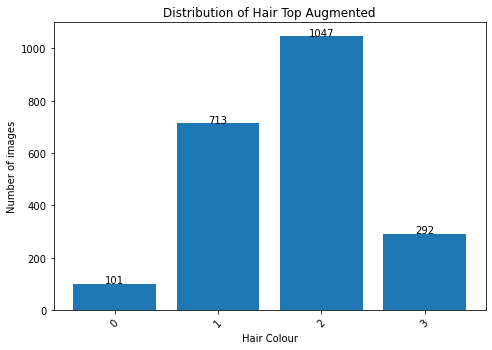

In [22]:
plot_freq(count_freq(data['hair_top']), "Distribution of Hair Top Augmented", dataset_dict['hair_top_id'],"hair_top augmented")

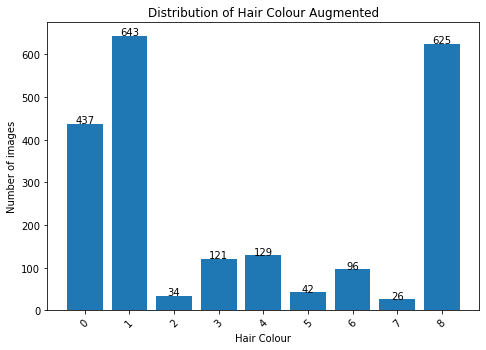

In [23]:
plot_freq(count_freq(data['hair_color']), "Distribution of Hair Colour Augmented", dataset_dict['hair_colour_id'],"Hair_Colour augmented")


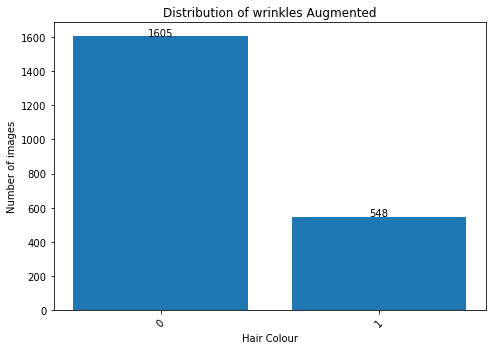

In [24]:
plot_freq(count_freq(data['wrinkles']), "Distribution of wrinkles Augmented", dataset_dict['wrinkles_id'],'wrinkles augmented')


In [25]:
plot_freq(count_freq(data['glasses']), "Distribution of glasses Augmented", dataset_dict['glasses_id'],"glasses augmented")


In [26]:
plot_freq(count_freq(data['freakles']), "Distribution of freckles Augmented", dataset_dict['freckles_id'],"freckles augmented")

In [27]:
"""
Loads images from disk to numpy array
"""
def load_images(datadir, dataframe):
    image_path = []
    image_annotation = []
    # loops through length of updated data
    for i in range(len(data)): # loop though the lenght of the data
        indexed_data = data.iloc[i]
        image_name = indexed_data[0]
        image_path.append(os.path.join(datadir,image_name.strip()))
        
        image_annotation.append([indexed_data[1],indexed_data[2],indexed_data[3],indexed_data[4],indexed_data[5]])
      
        
        
    image_paths = np.asarray(image_path)
    image_annotations = np.asarray(image_annotation)
    return image_paths, image_annotations


In [28]:
image_paths, image_annotations = load_images(root+image_data , data)

In [29]:
# splits the dataset into training data and training data
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, image_annotations, test_size = 0.2, random_state = 6) # data is split with 80% training and 20% validaiotn data
print('Training samples: {} \nValidation Samples: {}'.format(len(X_train), len(X_valid)))

Training samples: 1722 
Validation Samples: 431


# Image preprocessing

In [30]:
#function for pre processing
def img_preprocess(img):
  img = img[:, :, :3] # change shape to 3 dimentional array
  img = cv2.GaussianBlur(img, (3,3), 0 ) # smooths image out and reduces the noise of the image
  # above the arguments are the image, the size of the kernal and the deviation of the kernal
  img = cv2.resize(img, (200,200)) # resize the image to reduce the computational power needed
  # image as first argument tuple as second that the image will be resized too
  img = img/255 # nomalisation of the image
  return img # returns pre processed image

#### Check preprocessing works

In [31]:
image = image_paths[9] # selects an image that is currently set to index 100
original_image = mping.imread(image) # stores original image that has been read into this variable
preprocessed_image = img_preprocess(original_image) # same image that has been preprocessed using the defined function

fig, axes = plt.subplots(1, 2, figsize=(15,10)) # defines a sub plot to show the original and preprocessed images
fig.tight_layout() # formatting the images
axes[0].imshow(original_image) # show the original image
axes[0].set_title('Original Image') # title of the original image
axes[1].imshow(preprocessed_image) # preprocessed image
axes[1].set_title('Preprocessed Image') # title of the original image

Text(0.5, 1.0, 'Preprocessed Image')

### Batch generator to load images, preprocess and augment on the fly

In [32]:
#function for batch agumentation
def batch_generator(image_paths, annotations, batch_size, istraining):
  while True:
    batch_img = [] # stores image in list
    batch_annotations = [] # stores the annotation in a list 
    wrinkles,freakles,glasses,hair_colors,hair_tops = [], [],[],[],[]
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) -1 ) # randomly selects image
      
      # if statement to test between training images and validation images
      if istraining:
        # training data
        person = data.iloc[random_index]
        wrinkle = person["wrinkles"]
        freakle = person["freakles"]
        glass = person["glasses"]
        hair_color = person["hair_color"]
        hair_top = person["hair_top"]
        
        img,annotation= random_augment(image_paths[random_index],annotation = annotations[random_index]) # stores the randomly selected images and annotation in variables
        
        wrinkles.append(to_categorical(wrinkle, len(dataset_dict['wrinkles_id'])))
        freakles.append(to_categorical(freakle, len(dataset_dict['freckles_id'])))
        glasses.append(to_categorical(glass, len(dataset_dict['glasses_id'])))
        hair_colors.append(to_categorical(hair_color, len(dataset_dict['hair_colour_id'])))
        hair_tops.append(to_categorical(hair_top, len(dataset_dict['hair_top_id'])))
        
      else:
        # validaiton data
        img = mping.imread(image_paths[random_index])
        person = data.iloc[random_index]
        wrinkle = person["wrinkles"]
        freakle = person["freakles"]
        glass = person["glasses"]
        hair_color = person["hair_color"]
        hair_top = person["hair_top"]
        annotation = annotations[random_index]
        wrinkles.append(to_categorical(wrinkle, len(dataset_dict['wrinkles_id'])))
        freakles.append(to_categorical(freakle, len(dataset_dict['freckles_id'])))
        glasses.append(to_categorical(glass, len(dataset_dict['glasses_id'])))
        hair_colors.append(to_categorical(hair_color, len(dataset_dict['hair_colour_id'])))
        hair_tops.append(to_categorical(hair_top, len(dataset_dict['hair_top_id'])))
        
      img = img_preprocess(img) # call to function
      batch_img.append(img) # appends the image to list
      batch_annotations.append(annotation) # appends the annotation angle to list
      
    yield (np.asarray(batch_img), [np.array(wrinkles), np.array(freakles), np.array(glasses), np.array(hair_colors), np.array(hair_tops)]) # using yield to suspend the function
    wrinkles,freakles,glasses,hair_colors,hair_tops = [], [],[],[],[]

# Image augmentation

In [33]:
# image augmentation
def zoom(image):
  zoom = iaa.Affine(scale = (1, 1.4)) # zoom function set to between 1x and 1.4x zoom
  image = zoom.augment_image(image) # augments the zoom of image
  return image

In [34]:
# flipping augmentation
def img_random_flip(image): # function takes image and steering angle 
  image = cv2.flip(image, 1) # horizontal flip
  return image # returns the image and steering angle

In [35]:
# image panning
def pan(image):
  pan = iaa.Affine(translate_percent={'x': (-0.1,0.1), 'y':(0.1,0.1)}) # panning 10% left or right and 10% up or down
  image = pan.augment_image(image) # augments the image with pan function
  return image # returns an augmented image

In [36]:
# augmention for bightness
def img_random_brightness(image):
  brightness = iaa.Multiply((1.0,2.6)) # multiplys all pixels by a value
  image = brightness.augment_image(image) # augments the brightness of the image
  return image # returns an augmented image

In [37]:
#augmentation for hue and saturation
def img_hue_saturation(image):
    saturation = iaa.AddToHueAndSaturation((-50, 50), per_channel=True)
    image = saturation.augment_image(image)
    return image

### function to call a random augmentation on an image

In [40]:
# randomise the occurance of the augmentations
def random_augment(image,annotation):
  image = mping.imread(image)
  if np.random.rand() < 0.99: # 99% of iamges will be augmented
    image = pan(image)
   # print("pan")
  if np.random.rand() < 0.99: # 99% of iamges will be augmented
    image = zoom(image)
   # print("Zoom")
  if np.random.rand() < 0.99: # 99% of iamges will be augmented
    image = img_random_brightness(image)
   # print("Brightness")
  if np.random.rand() < 0.99: # 99% of iamges will be augmented
    image = img_random_flip(image)
    #print("Flipped")
  if np.random.rand() < 0.99: # 99% of iamges will be augmented
    image = img_hue_saturation(image)
  return image,annotation

### Check batch generator is working correctly

Text(0.5, 1.0, 'Validaiton Image')

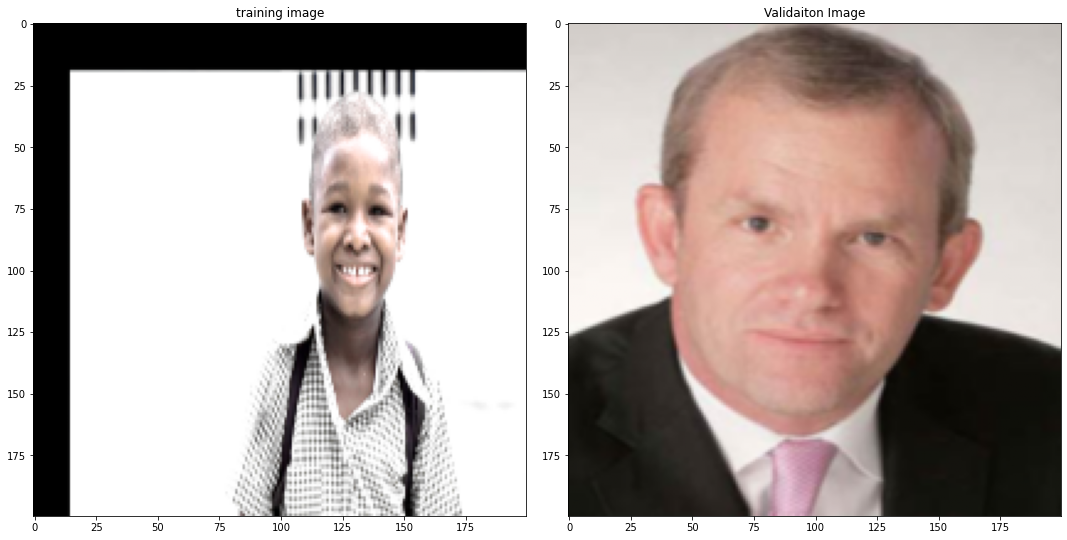

In [41]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15,10)) # plot to display the images
fig.tight_layout() # tidy up the plot

axs[0].imshow(x_train_gen[0]) # original image
axs[0].set_title('training image') # title of the original image

axs[1].imshow(x_valid_gen[0]) # displays the brightness augmented image
axs[1].set_title('Validaiton Image') # titles the augmented image

# Model creation 

In [42]:
from sklearn.utils import class_weight
computed_class_weight_w = class_weight.compute_class_weight('balanced',np.unique((data['wrinkles'])),(data['wrinkles']))
print("wrinkles\n",computed_class_weight_w,"\n")
computed_class_weight_f = class_weight.compute_class_weight('balanced',np.unique((data['freakles'])),(data['freakles']))
print("freakles\n",computed_class_weight_f,"\n")
computed_class_weight_g = class_weight.compute_class_weight('balanced',np.unique((data['glasses'])),(data['glasses']))
print("glasses\n",computed_class_weight_g,"\n")
computed_class_weight_hc = class_weight.compute_class_weight('balanced',np.unique((data['hair_color'])),(data['hair_color']))
print("hair Colour\n",computed_class_weight_hc,"\n")
computed_class_weight_ht = class_weight.compute_class_weight('balanced',np.unique((data['hair_top'])),(data['hair_top']))
print("hair top\n",computed_class_weight_ht,"\n")

wrinkles
 [0.67071651 1.96441606] 

freakles
 [0.61374002 2.69799499] 

glasses
 [0.3971592  2.82545932 7.80072464] 

hair Colour
 [0.54741927 0.37204078 7.03594771 1.97704316 1.85443583 5.6957672
 2.49189815 9.2008547  0.38275556] 

hair top
 [5.32920792 0.75490884 0.51408787 1.84332192] 



/home/michael/anaconda3/envs/comp1801/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning:

Pass classes=[0 1], y=0       0
1       0
2       0
3       0
4       0
       ..
2148    1
2149    0
2150    0
2151    1
2152    1
Name: wrinkles, Length: 2153, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error

/home/michael/anaconda3/envs/comp1801/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning:

Pass classes=[0 1], y=0       0
1       0
2       0
3       0
4       0
       ..
2148    0
2149    0
2150    0
2151    0
2152    1
Name: freakles, Length: 2153, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error

/home/michael/anaconda3/envs/comp1801/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning:

Pass classes=[0 1 2], y=0       0
1       1
2       0
3       0
4       0
       ..
2148    2
2149    0
2150    

In [43]:
class_weights = dict(enumerate((computed_class_weight_w,computed_class_weight_f,computed_class_weight_g,computed_class_weight_hc,computed_class_weight_ht)))
class_weights

{0: array([0.67071651, 1.96441606]),
 1: array([0.61374002, 2.69799499]),
 2: array([0.3971592 , 2.82545932, 7.80072464]),
 3: array([0.54741927, 0.37204078, 7.03594771, 1.97704316, 1.85443583,
        5.6957672 , 2.49189815, 9.2008547 , 0.38275556]),
 4: array([5.32920792, 0.75490884, 0.51408787, 1.84332192])}

In [44]:
first_layer = Input(shape = (200, 200, 3))

x = Conv2D(32, (3,3),  activation = ACTIVATION_LAYER, padding = "same")(first_layer)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

#x = Conv2D(64, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
#x = BatchNormalization()(x)
#x = Conv2D(64, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
#x = BatchNormalization()(x)
#x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)

### Output layers, 5 in total for each class

In [45]:
 # for wrinkles prediction
w = Dense(512, activation = ACTIVATION_LAYER)(x)
w = Dropout(0.6)(w)
w = Dense(64, activation = ACTIVATION_LAYER)(x)
wrinkles_output = Dense(units=2, activation=ACTIVATION_OUTPUT, name='wrinkles_output')(w)

In [46]:
# for freakles prediction
f = Dense(units=128, activation='relu')(x)
f = Dropout(0.6)(f)
f = Dense(units=32, activation='relu')(f)
freakles_output = Dense(units=2, activation=ACTIVATION_OUTPUT, name='freakles_output')(f)

In [47]:
# for glasses prediction
g = Dense(units=128, activation='relu')(x)
g = Dropout(0.6)(g)
g = Dense(units=32, activation='relu')(g)
glasses_output = Dense(units=3, activation=ACTIVATION_OUTPUT, name='glasses_output')(g)

In [48]:
# for hair colour prediction
hc= Dense(units=1024, activation='relu')(x)
#hc = Dropout(0.6)(hc)
#hc = Dense(units=128, activation='relu')(hc)
#hc = Dropout(0.6)(hc)
#hc = Dense(units=128, activation='relu')(hc)
hc = Dropout(0.6)(hc)
hc = Dense(units=16, activation='relu')(hc)
hair_colour_output = Dense(units=9, activation=ACTIVATION_OUTPUT, name='hair_colour_output')(hc)

In [49]:
# for hair top prediction
ht= Dense(units=1024, activation='relu')(x)
ht = Dropout(0.6)(ht)
ht = Dense(units=16, activation='relu')(ht)
ht = Dropout(0.6)(ht)
ht = Dense(units=16, activation='relu')(ht)
hair_top_output = Dense(units=4, activation=ACTIVATION_OUTPUT, name='hair_top_output')(ht)

In [50]:
model = Model(first_layer, outputs=[wrinkles_output, freakles_output, glasses_output,hair_colour_output,hair_top_output])

# Compile Model

In [53]:
model.compile(optimizer=OPTIMIZER,
              loss={'wrinkles_output': 'categorical_crossentropy', 
                    'freakles_output': 'categorical_crossentropy', 
                    'glasses_output': 'categorical_crossentropy',
                    'hair_colour_output': 'categorical_crossentropy',
                    'hair_top_output': 'categorical_crossentropy'},
              #loss_weights={'age_output': 2., 'race_output': 1.5, 'gender_output': 1.},
              loss_weights={'wrinkles_output': 2, 
                    'freakles_output': 2, 
                    'glasses_output': 1,
                    'hair_colour_output': 0.8,
                    'hair_top_output': 0.8},
              metrics={'wrinkles_output': 'accuracy', 
                       'freakles_output': 'accuracy', 
                       'glasses_output': 'accuracy',
                       'hair_colour_output': 'accuracy',
                       'hair_top_output': 'accuracy'
                      })


In [54]:
from contextlib import redirect_stdout
if not os.path.exists('%s/Model_Data/%s/modelsummary.txt' %(root, MODEL_NAME)):
    with open('%s/Model_Data/%s/modelsummary.txt' %(root, MODEL_NAME), 'w') as f:
        with redirect_stdout(f):
            model.summary()
            print("Summary Written.")
else:
    print("Summary already saved.")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 200, 200, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 200, 200, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 200, 200, 32) 9248        batch_normalization[0][0]        
______________________________________________________________________________________________

# Train model

In [ ]:
history = model.fit(batch_generator(X_train, y_train, BATCH_SIZE, 1), # intergrated batch generator into training
                              steps_per_epoch=STEPS, # 300 steps with a batch size of 250 is 75,000 images per epoch
                              epochs=EPOCS, # set 10 epochs
                              validation_data = batch_generator(X_valid,y_valid, 32, 0), # intergration of batch generator
                              validation_steps = 20, # number of steps for the validaiton of data
                              verbose = 1) # shuffles the dataset

# Check values of accuracy model has achived 

In [ ]:
# plot history graphs from model training
def plot_history_graphs(data1, data2,title):
    plt.plot(history.history[data1], label = data1)
    plt.plot(history.history[data2], label = data2)
    plt.grid(True)
    plt.tight_layout()
    plt.title('Model %s'%title)
    plt.ylabel(data1)
    plt.xlabel("Epoch")
    plt.legend()
    if not os.path.exists("%s/Model_Data/%s/%s.png"% (root,MODEL_NAME,data1)):
        plt.savefig("%s/Model_Data/%s/%s.png"% (root,MODEL_NAME,data1))

In [ ]:
overall = plot_history_graphs('loss','val_loss','Overall loss')

In [ ]:
plot_history_graphs('hair_top_output_accuracy','val_hair_top_output_accuracy','Hair Top')

In [ ]:
plot_history_graphs('hair_colour_output_accuracy','val_hair_colour_output_accuracy','Hair Colour')

In [ ]:
plot_history_graphs('glasses_output_accuracy','val_glasses_output_accuracy','Glasses')

In [ ]:
plot_history_graphs('wrinkles_output_accuracy','val_wrinkles_output_accuracy','Wrinkles')

In [ ]:
plot_history_graphs('freakles_output_accuracy','val_freakles_output_accuracy','Freckles')

# Save model

In [ ]:
# save model weights
if not os.path.exists("%s/Model_Data/%s/%s.h5" % (root,MODEL_NAME,MODEL_NAME)):
        model.save("%s/Model_Data/%s/%s.h5" % (root,MODEL_NAME,MODEL_NAME))

# Model Evaluation

In [ ]:
def evaluation_batch_generator(image_paths, annotations,COUNTS, batch_size = 128):
    batch_img = [] # stores image in list
    batch_annotations = [] # stores the annotation in a list 
    wrinkles,freakles,glasses,hair_colors,hair_tops = [], [],[],[],[]
    counts = 0
    for i in range(batch_size):
        if(counts < COUNTS):
            random_index = random.randint(0, len(image_paths) -1 ) # randomly selects image
            img = mping.imread(image_paths[random_index])
            person = data.iloc[random_index]
            wrinkle = person["wrinkles"]
            freakle = person["freakles"]
            glass = person["glasses"]
            hair_color = person["hair_color"]
            hair_top = person["hair_top"]
            annotation = annotations[random_index]
            wrinkles.append(to_categorical(wrinkle, len(dataset_dict['wrinkles_id'])))
            freakles.append(to_categorical(freakle, len(dataset_dict['freckles_id'])))
            glasses.append(to_categorical(glass, len(dataset_dict['glasses_id'])))
            hair_colors.append(to_categorical(hair_color, len(dataset_dict['hair_colour_id'])))
            hair_tops.append(to_categorical(hair_top, len(dataset_dict['hair_top_id'])))

            img = img_preprocess(img) # call to function
            batch_img.append(img) # appends the image to list
            batch_annotations.append(annotation) # appends the annotation angle to list
            counts+=1
            yield (np.asarray(batch_img), [np.array(wrinkles), np.array(freakles), np.array(glasses), np.array(hair_colors), np.array(hair_tops)]) # using yield to suspend the function
            wrinkles,freakles,glasses,hair_colors,hair_tops = [], [],[],[],[]

In [ ]:
print(X_valid.shape,y_valid.shape)
score = model.evaluate(evaluation_batch_generator(X_valid, y_valid,12),verbose=1)

In [ ]:
score_output = print('Losses\nTest loss: %s\nWrinkles loss: %s \nFreckles loss: %s \nGlasses loss: %s \nHair Color loss: %s \nHair Top loss: %s \n\nAccuracy\nWrinkles accuracy: %s \nFreckles accuracy: %s \nGlasses accuracy: %s \nHair Color accuracy: %s \nHair Top accuracy: %s \n' 
                     %(score[0], score[1],score[2], score[3],score[4], score[5],score[6], score[7],score[8], score[9],score[10]))



In [ ]:
if not os.path.exists('%s/Model_Data/%s/evaluation_score.txt' %(root, MODEL_NAME)):
    with open('%s/Model_Data/%s/evaluation_score.txt' %(root, MODEL_NAME), 'w') as f:
        with redirect_stdout(f):
            print('Test loss: %s\nWrinkles loss: %s \nFreckles loss: %s \nGlasses loss: %s \nHair Color loss: %s \nHair Top loss: %s \nWrinkles accuracy: %s \nFreckles accuracy: %s \nGlasses accuracy: %s \nHair Color accuracy: %s \nHair Top accuracy: %s \n' 
                     %(score[0], score[1],score[2], score[3],score[4], score[5],score[6], score[7],score[8], score[9],score[10]))
    print("Score Written.")
else:
    print("Score Already present")
score_output